In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import re
import string
from wordcloud import WordCloud
from collections import Counter


from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scikitplot.metrics import plot_confusion_matrix, plot_roc



In [2]:
data=pd.read_csv('sentiment-analysis.csv')
data

,"Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score"
0,"""I love this product!"", Positive, Twitter, 202..."
1,"""The service was terrible."", Negative, Yelp Re..."
2,"""This movie is amazing!"", Positive, IMDb, 2023..."
3,"""I'm so disappointed with their customer suppo..."
4,"""Just had the best meal of my life!"", Positive..."
...,...
93,"""I can't stop listening to this song. It's my ..."
94,"""Their website is so confusing and poorly desi..."
95,"""I had an incredible experience at the theme p..."
96,NaN


In [3]:
# Split columns and rename them
data = data['Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score'].str.split(',', expand=True)
data = data.rename(columns={
    0: 'Text',
    1: 'Sentiment',
    2: 'Source',
    3: 'Date/Time',
    4: 'User ID',
    5: 'Location',
    6: 'Confidence Score'
})

In [4]:
data

,Text,Sentiment,Source,Date/Time,User ID,Location,Confidence Score
0,"""I love this product!""",Positive,Twitter,2023-06-15 09:23:14,@user123,New York,0.85
1,"""The service was terrible.""",Negative,Yelp Reviews,2023-06-15 11:45:32,user456,Los Angeles,0.65
2,"""This movie is amazing!""",Positive,IMDb,2023-06-15 14:10:22,moviefan789,London,0.92
3,"""I'm so disappointed with their customer suppo...",Negative,Online Forum,2023-06-15 17:35:11,forumuser1,Toronto,0.78
4,"""Just had the best meal of my life!""",Positive,TripAdvisor,2023-06-16 08:50:59,foodie22,Paris,0.88
...,...,...,...,...,...,...,...
93,"""I can't stop listening to this song. It's my ...",Positive,Spotify,2023-07-03 09:17:52,musiclover789,Berlin,0.91
94,"""Their website is so confusing and poorly desi...",Negative,Website Review,2023-07-03 11:59:18,user789,Toronto,0.68
95,"""I had an incredible experience at the theme p...",Positive,Trip Report,2023-07-03 14:40:05,thrillseeker1,Orlando,0.89
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#checking for null values
data.isna().sum()

Text                2
Sentiment           2
Source              2
Date/Time           2
User ID             2
Location            2
Confidence Score    2
dtype: int64

In [6]:
#Checking for duplicate values
data.duplicated().sum()

22

In [7]:
# Drop duplicates and NaN values
df = data.drop_duplicates()
df = data.dropna()

In [8]:
# Convert Date/Time to datetime format
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# Extract Month, Day, and Hour from Date/Time
df['Month'] = df['Date/Time'].dt.month
df['Day'] = df['Date/Time'].dt.day
df['hour'] = df['Date/Time'].dt.hour

C:\Users\jibin\AppData\Local\Temp\ipykernel_17028\1791783218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date/Time'] = pd.to_datetime(df['Date/Time'])
C:\Users\jibin\AppData\Local\Temp\ipykernel_17028\1791783218.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df['Date/Time'].dt.month
C:\Users\jibin\AppData\Local\Temp\ipykernel_17028\1791783218.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [9]:
# Calculate total words in each text
df['Total Words'] = df['Text'].apply(lambda x: len(x.split()))

C:\Users\jibin\AppData\Local\Temp\ipykernel_17028\3639590432.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total Words'] = df['Text'].apply(lambda x: len(x.split()))


In [10]:
# Function to count total characters in a text
def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

In [11]:
# Calculate total characters in each text
df['Total Chars'] = df["Text"].apply(count_total_words)

C:\Users\jibin\AppData\Local\Temp\ipykernel_17028\420610150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total Chars'] = df["Text"].apply(count_total_words)


In [12]:
# Convert text to lowercase
def convert_lowercase(text):
    text = text.lower()
    return text

In [13]:
df['Text'] = df['Text'].apply(convert_lowercase)

C:\Users\jibin\AppData\Local\Temp\ipykernel_17028\4054655558.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'] = df['Text'].apply(convert_lowercase)


In [14]:
# Remove punctuation from text
exclude = string.punctuation
def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

df['Text'] = df['Text'].apply(remove_punc)

C:\Users\jibin\AppData\Local\Temp\ipykernel_17028\1944487211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'] = df['Text'].apply(remove_punc)


In [15]:
# Remove stopwords from text
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

df['Text'] = df['Text'].apply(remove_stopwords)

C:\Users\jibin\AppData\Local\Temp\ipykernel_17028\1020693099.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'] = df['Text'].apply(remove_stopwords)


In [16]:
# Perform stemming on text
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))
    return " ".join(new_list)

df['Text'] = df['Text'].apply(perform_stemming)

C:\Users\jibin\AppData\Local\Temp\ipykernel_17028\210301140.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'] = df['Text'].apply(perform_stemming)


In [17]:
# Calculate total words after text transformation
df['Total Words After Transformation'] = df['Text'].apply(lambda x: np.log(len(x.split())))


C:\Users\jibin\AppData\Local\Temp\ipykernel_17028\1699204687.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total Words After Transformation'] = df['Text'].apply(lambda x: np.log(len(x.split())))


In [18]:
# Display the transformed DataFrame
print(df.head())

                           Text  Sentiment         Source           Date/Time  \
0                  love product   Positive        Twitter 2023-06-15 09:23:14   
1                servic terribl   Negative   Yelp Reviews 2023-06-15 11:45:32   
2                     movi amaz   Positive           IMDb 2023-06-15 14:10:22   
3  im disappoint custom support   Negative   Online Forum 2023-06-15 17:35:11   
4                best meal life   Positive    TripAdvisor 2023-06-16 08:50:59   

        User ID      Location Confidence Score  Month  Day  hour  Total Words  \
0      @user123      New York             0.85      6   15     9            4   
1       user456   Los Angeles             0.65      6   15    11            4   
2   moviefan789        London             0.92      6   15    14            4   
3    forumuser1       Toronto             0.78      6   15    17            7   
4      foodie22         Paris             0.88      6   16     8            8   

   Total Chars  Total Word

<Axes: xlabel='Sentiment', ylabel='Count'>

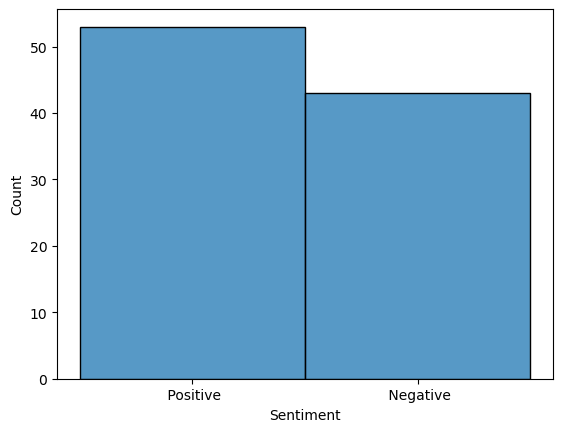

In [19]:
# Plot sentiment distribution
sns.histplot(data=df, x='Sentiment')

<Axes: xlabel='Count', ylabel='Source'>

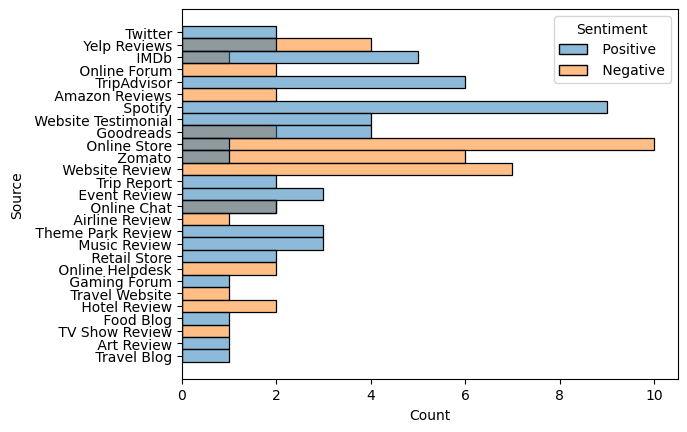

In [20]:
# Plot sentiment distribution by source
sns.histplot(data=df, y='Source', hue='Sentiment')

<Axes: xlabel='Count', ylabel='Location'>

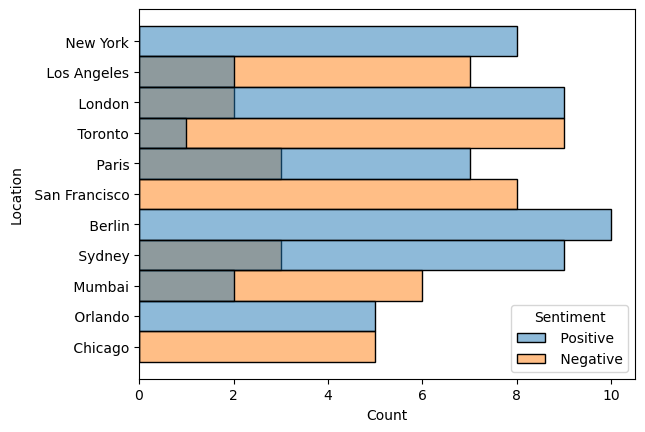

In [21]:
# Plot sentiment distribution by location
sns.histplot(data=df, y='Location', hue='Sentiment')

C:\Users\jibin\AppData\Local\Temp\ipykernel_17028\1616595610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Confidence Score'] = df['Confidence Score'].astype(float)


<Axes: xlabel='Confidence Score', ylabel='Count'>

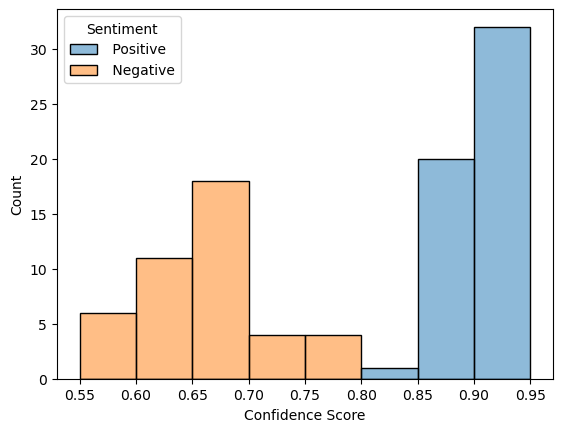

In [22]:
# Convert Confidence Score to float
df['Confidence Score'] = df['Confidence Score'].astype(float)
# Plot sentiment distribution by Confidence Score
sns.histplot(data=df, x='Confidence Score', hue='Sentiment')

<Axes: xlabel='Month', ylabel='Count'>

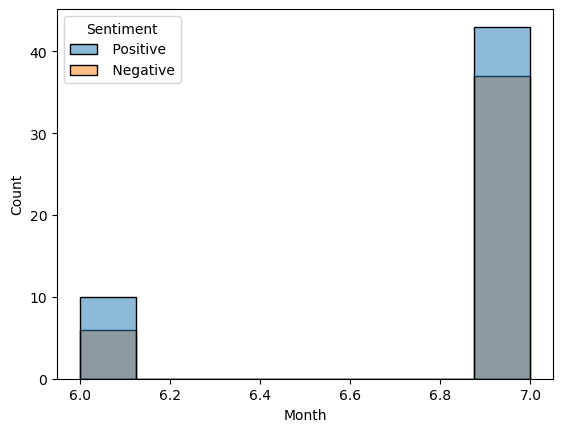

In [23]:
# Plot sentiment distribution by month
sns.histplot(data=df, x='Month', hue='Sentiment')

<Axes: xlabel='Day', ylabel='Count'>

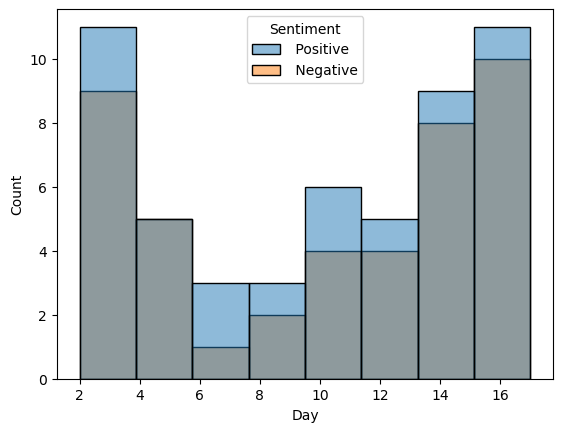

In [24]:
# Plot sentiment distribution by day
sns.histplot(data=df, x='Day', hue='Sentiment')

<Axes: xlabel='hour', ylabel='Count'>

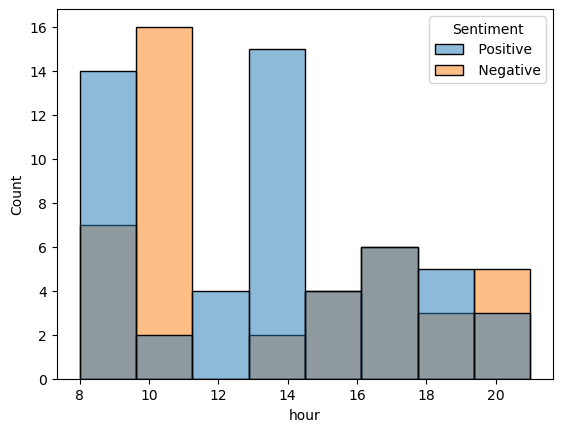

In [25]:
# Plot sentiment distribution by hour
sns.histplot(data=df, x='hour', hue='Sentiment')

C:\Users\jibin\AppData\Local\Temp\ipykernel_17028\1937885122.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=df['Total Words'], hue=df['Sentiment'], palette='winter', shade=True)


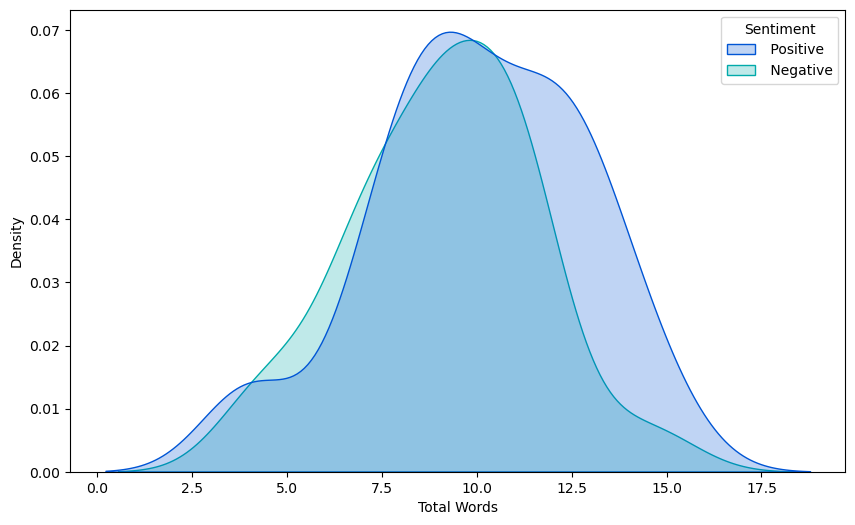

In [26]:
# Plot KDE plot for Total Words
plt.figure(figsize=(10, 6))
sns.kdeplot(x=df['Total Words'], hue=df['Sentiment'], palette='winter', shade=True)
plt.show()

C:\Users\jibin\AppData\Local\Temp\ipykernel_17028\670255460.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=df['Total Chars'], hue=df['Sentiment'], palette='winter', shade=True)


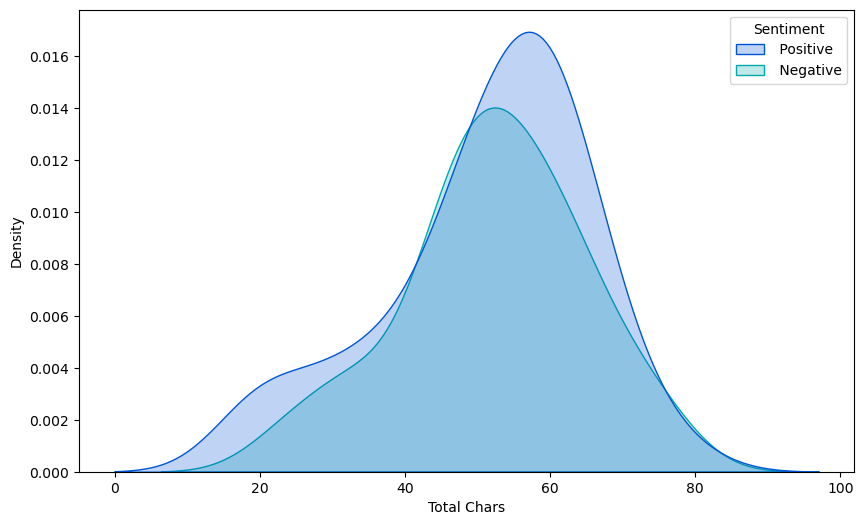

In [27]:
# Plot KDE plot for Total Chars
plt.figure(figsize=(10, 6))
sns.kdeplot(x=df['Total Chars'], hue=df['Sentiment'], palette='winter', shade=True)
plt.show()

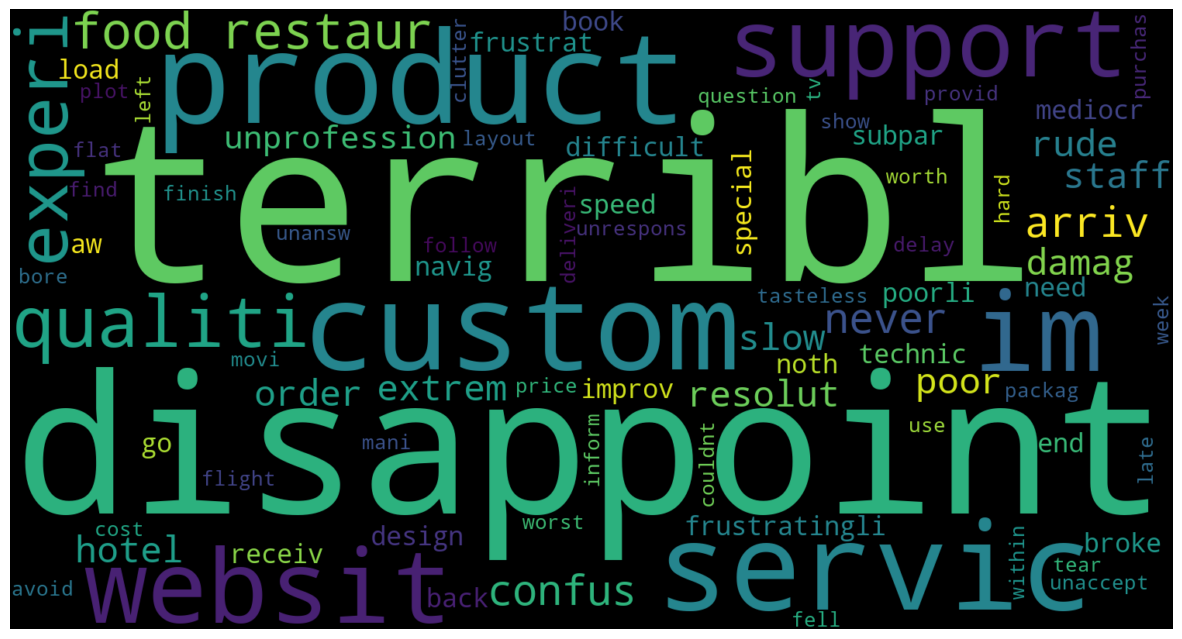

In [28]:
# Generate and display WordCloud for Negative sentiment
text_neg = " ".join(df[df['Sentiment'] == ' Negative']['Text'])
plt.figure(figsize=(15, 10))
wordcloud_neg = WordCloud(max_words=500, height=800, width=1500, background_color="black", colormap='viridis').generate(text_neg)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis('off')
plt.show()

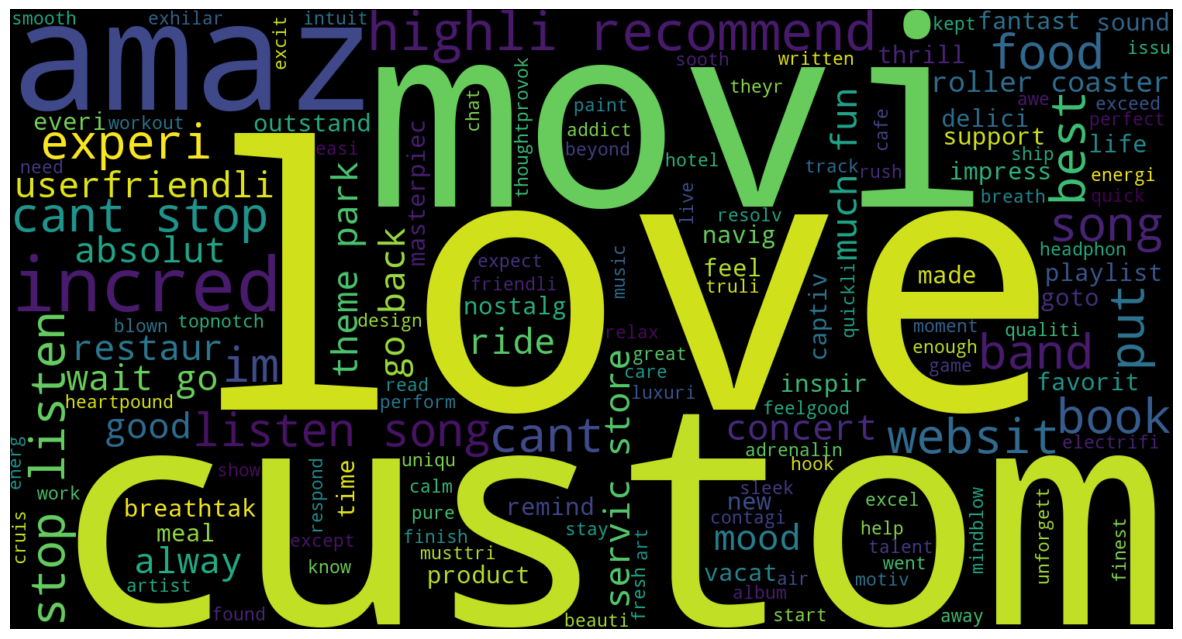

In [29]:
# Generate and display WordCloud for Positive sentiment
text_pos = " ".join(df[df['Sentiment'] == ' Positive']['Text'])
plt.figure(figsize=(15, 10))
wordcloud_pos = WordCloud(max_words=500, height=800, width=1500, background_color="black", colormap='viridis').generate(text_pos)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis('off')
plt.show()

In [30]:
# Count and display most common negative words
all_negative_words = []
for sentence in df[df['Sentiment'] == ' Negative']['Text'].to_list():
    for word in sentence.split():
        all_negative_words.append(word)

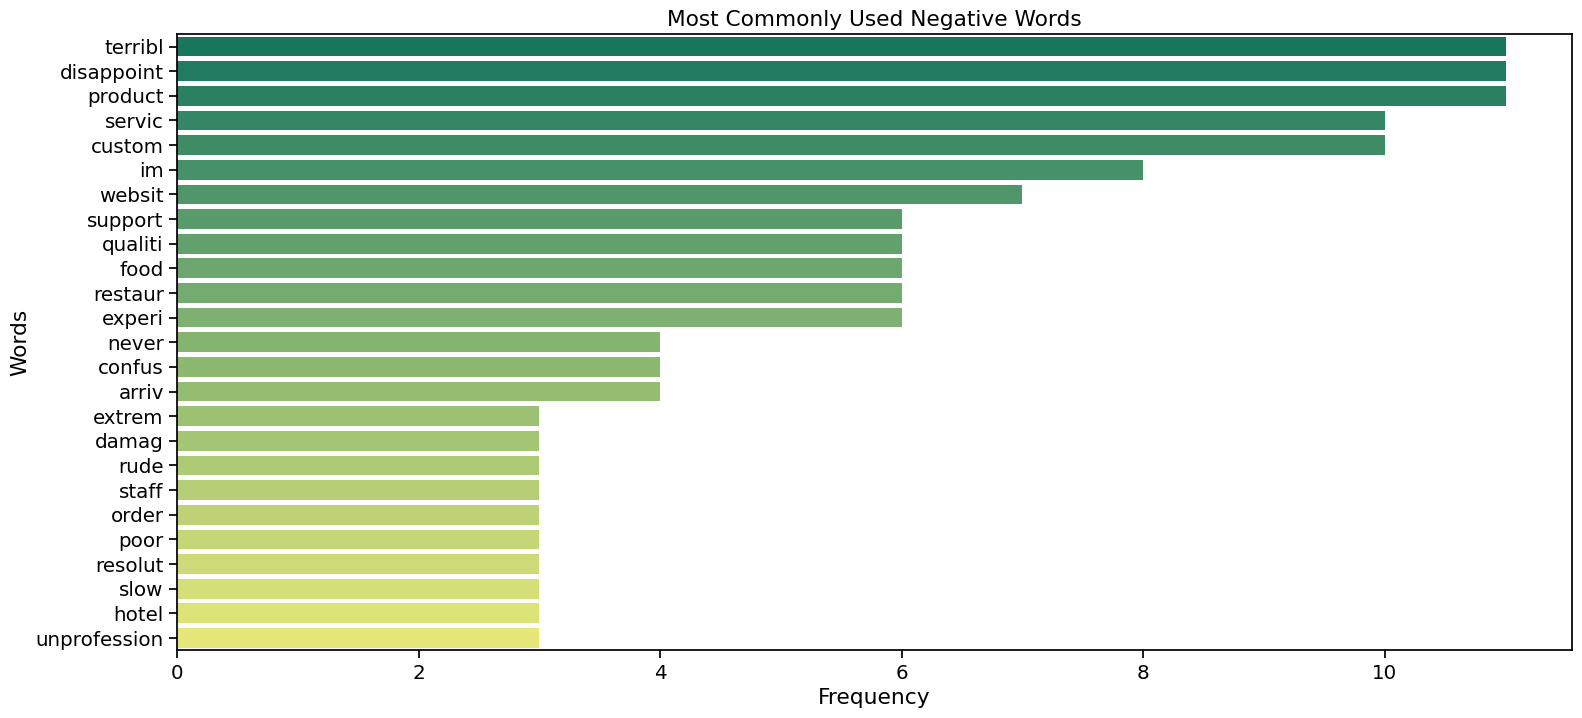

In [31]:
df_neg = pd.DataFrame(Counter(all_negative_words).most_common(25), columns=['Word', 'Frequency'])
sns.set_context('notebook', font_scale=1.3)
plt.figure(figsize=(18, 8))
sns.barplot(y=df_neg['Word'], x=df_neg['Frequency'], palette='summer')
plt.title("Most Commonly Used Negative Words")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

In [32]:
# Count and display most common positive words
all_positive_words = []
for sentence in df[df['Sentiment'] == ' Positive']['Text'].to_list():
    for word in sentence.split():
        all_positive_words.append(word)

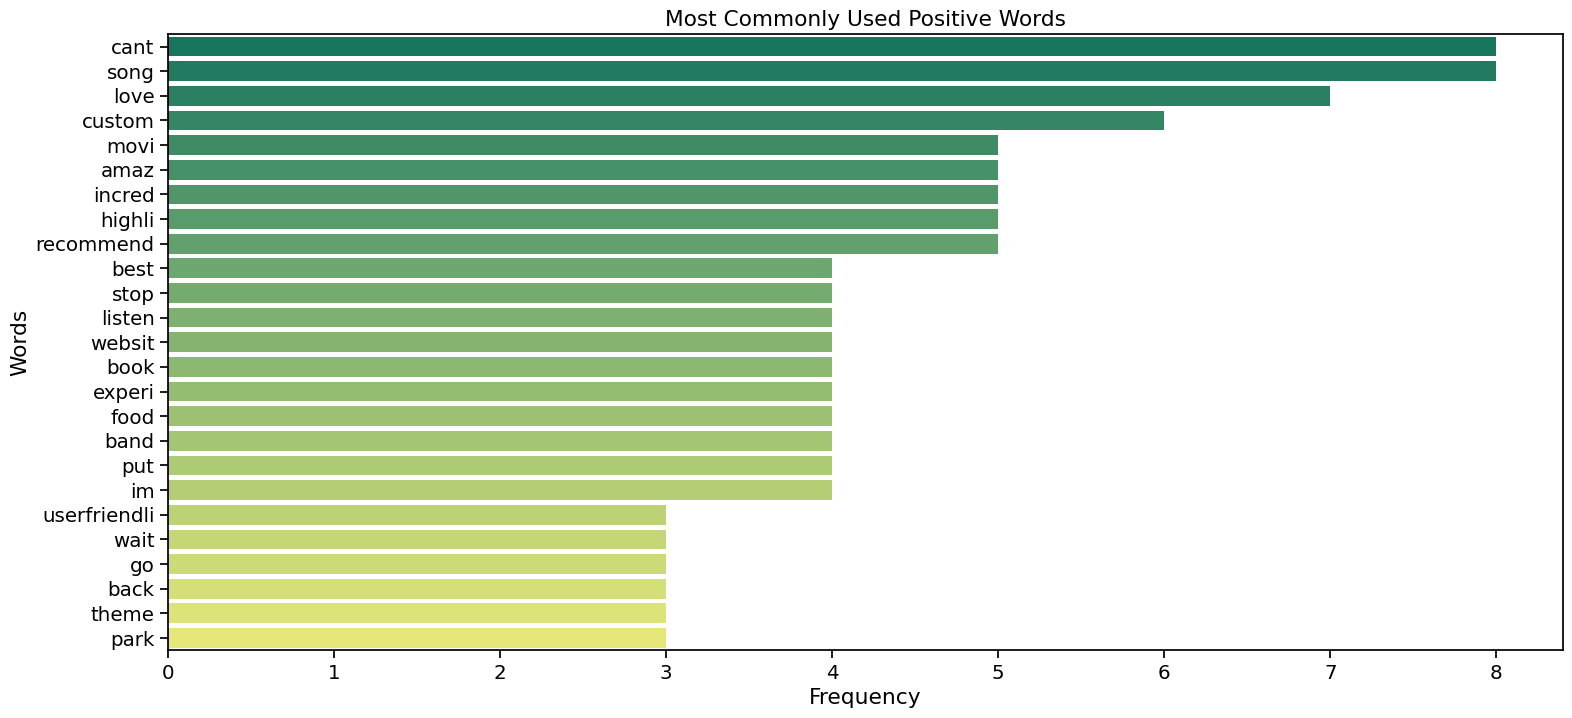

In [33]:
df_pos = pd.DataFrame(Counter(all_positive_words).most_common(25), columns=['Word', 'Frequency'])
sns.set_context('notebook', font_scale=1.3)
plt.figure(figsize=(18, 8))
sns.barplot(y=df_pos['Word'], x=df_pos['Frequency'], palette='summer')
plt.title("Most Commonly Used Positive Words")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

In [34]:
# Replace sentiment labels with numerical values
df['Sentiment'] = df['Sentiment'].replace({' Negative': 0, ' Positive': 1})


C:\Users\jibin\AppData\Local\Temp\ipykernel_17028\1301958924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Sentiment'].replace({' Negative': 0, ' Positive': 1})


In [35]:
# Split the data for training and testing
X = df["Text"]
y = df['Sentiment'].values

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
# Apply TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=2500, min_df=2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [38]:
# Function to train and evaluate the model
def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    sns.set_context('notebook', font_scale=1.3)
    fig, ax = plt.subplots(1, 2, figsize=(25, 8))
    ax1 = plot_confusion_matrix(y_test, y_pred, ax=ax[0], cmap='YlGnBu')
    ax2 = plot_roc(y_test, y_prob, ax=ax[1], plot_macro=False, plot_micro=False, cmap='summer')


Accuracy of the model: 0.95
Precision Score of the model: 1.0
Recall Score of the model: 0.909


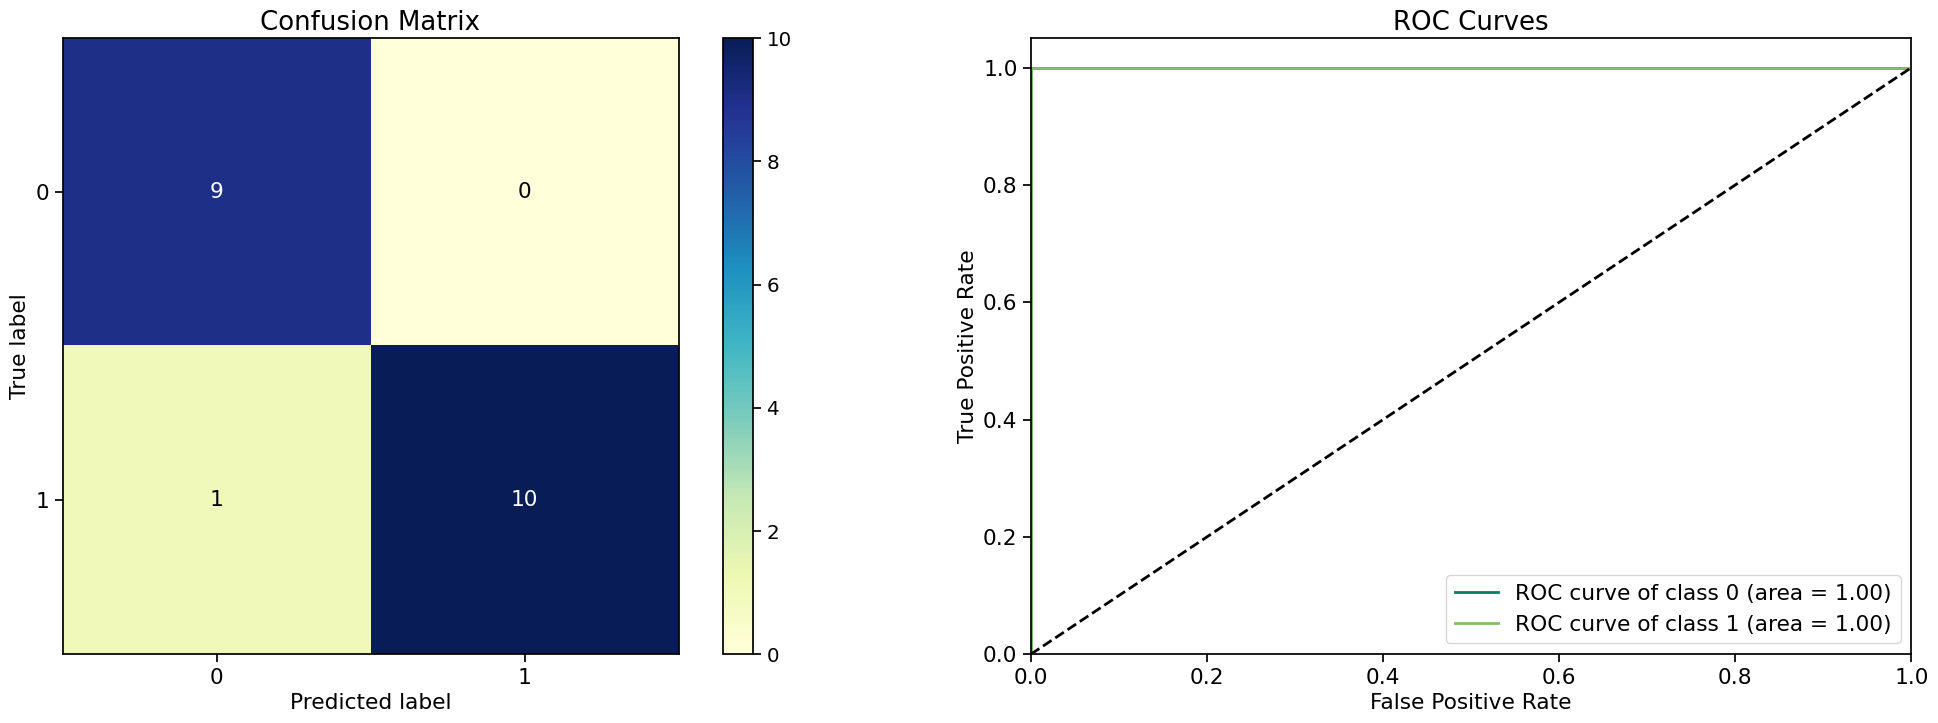

In [39]:
# Train and evaluate Naive Bayes model
nb = MultinomialNB()
train_model(nb)

Accuracy of the model: 0.95
Precision Score of the model: 0.917
Recall Score of the model: 1.0


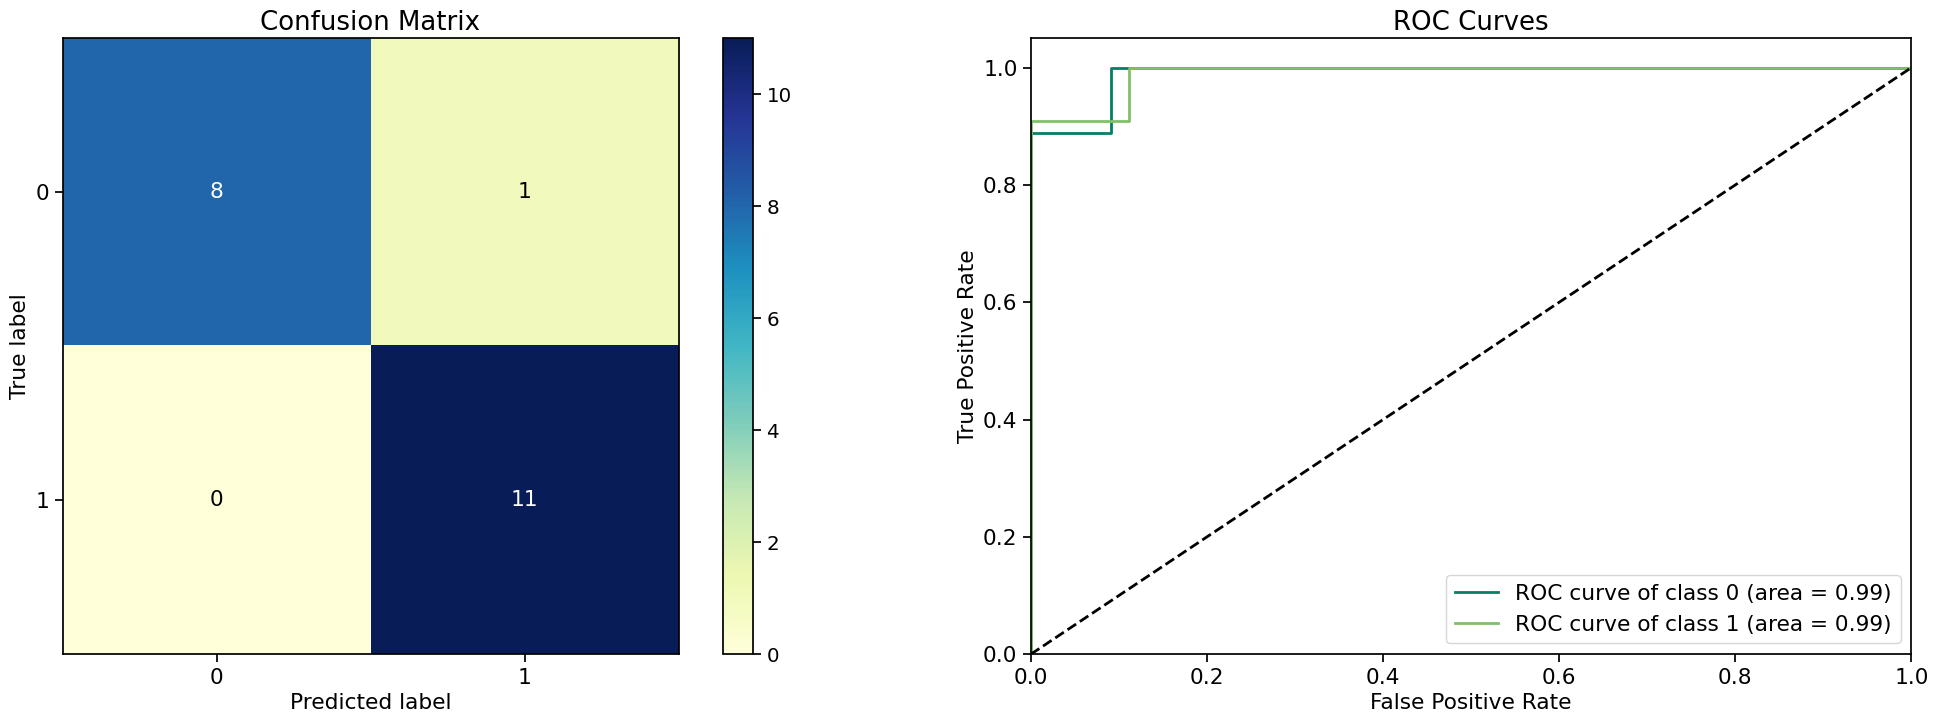

In [40]:
# Train and evaluate Random Forest model
rf = RandomForestClassifier(n_estimators=300)
train_model(rf)